In [1]:
from sympy import *
from sympy.abc import *
from sympy.galgebra.ga import *
import numpy as np
from numpy import linalg as LA
from __future__ import print_function
init_printing()

## PDE 
The acoustic wave equation for the square slowness m and a source q is given in 3D by :

\begin{cases} 
 &m \frac{d^2 u(x,t)}{dt^2} - \nabla^2 u(x,t) =q  \\
 &u(.,0) = 0 \\
 &\frac{d u(x,t)}{dt}|_{t=0} = 0 
\end{cases}

with the zero initial conditons to guaranty unicity of the solution

In [2]:
p=Function('p')
m,s,h = symbols('m s h')
m=M(x,y)
q=Q(x,y,t)
d=D(x,y,t)

### Time and space  discretization as a Taylor expansion.

The time discretization is define as a second order ( $ O (dt^2)) $) centered finite difference to get an explicit Euler scheme easy to solve by steping in time. 

$ \frac{d^2 u(x,t)}{dt^2} \simeq \frac{u(x,t+dt) - 2 u(x,t) + u(x,t-dt)}{dt^2} + O(dt^2) $

And we define the space discretization also as a Taylor serie, with oder chosen by the user. This can either be a direct expansion of the second derivative bulding the laplacian, or a combination of first oder space derivative. The second option can be a better choice in case you would want to extand the method to more complex wave equations involving first order derivatives in chain only.

$ \frac{d^2 u(x,t)}{dt^2} \simeq \frac{1}{dx^2} \sum_k \alpha_k (u(x+k dx,t)+u(x-k dx,t)) + O(dx^k) $

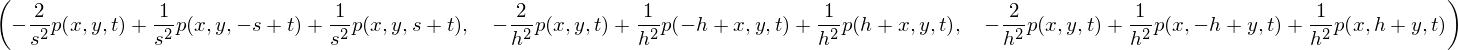

In [3]:
dtt=as_finite_diff(p(x,y,t).diff(t,t), [t-s,t, t+s])
# Spacial finite differences can easily be extended to higher order by increasing the list of sampling point in the next expression. 
# Be sure to keep this stencil symmetric and everything else in the notebook will follow.
dxx=as_finite_diff(p(x,y,t).diff(x,x), [x-h,x, x+h]) 
dyy=as_finite_diff(p(x,y,t).diff(y,y), [y-h,y, y+h])
dtt,dxx,dyy

### Solve forward in time 

The wave equation is then solved forward in time by 

\begin{align}
 \color{red}{\text{ For  }} &\text{ t = 0 to T  } \\
  &u(x,t+dt)  = 2 u(x,t) - u(x,t-dt) + \frac{dt^2}{m} (\Delta u(x,t) + q(x,t)) \\
  \color{red}{\text{ end  }}
\end{align}

In [4]:
# Forward wave equation
wave_equation = dtt- 1/m*(dxx+dyy) - q
stencil = solve(wave_equation,p(x,y,t+s))[0]
ts=lambdify((p(x,y,t-s),p(x-h,y,t), p(x,y,t), p(x+h,y,t),p(x,y-h,t), p(x,y+h,t), q , m, s, h),stencil,"numpy")


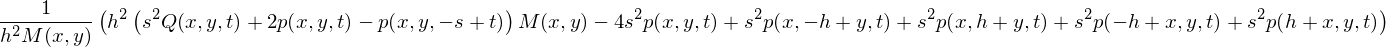

In [5]:
stencil

## Rewriting the discret PDE as part of an Inversion
### Accuracy and rigourousness of the dicretization

The above axpression are good for modelling. However, if you want to include a wave equation solver into an Inversion workflow, a more rigourous study of the discretization must be done. We can rewrite a single time step as follows 

$ A_3  u(x,t+dt)  = A_1 u(x,t) + A_2 u(x,t-dt) +q(x,t)$

where $ A_1,A_2,A_3 $ are square, invertible matrices, and symetric without any boundary conditions. In more details we have :

\begin{align}
& A_1 = \frac{2}{dt^2 m} + \Delta \\
& A_2 = \frac{-1}{dt^2 m} \\
& A_3 = \frac{1}{dt^2 m}
\end{align}

We can the write the action of the adjoint wave equation operator. The adjoint wave equation is defined by 
\begin{cases} 
 &m \frac{d^2 v(x,t)}{dt^2} - \nabla^2 v(x,t) = \delta d  \\
 &v(.,T) = 0 \\
 &\frac{d v(x,t)}{dt}|_{t=T} = 0 
\end{cases}

but by choosing to discretize first we will not discretize this equation. Instead we will take the adjoint of the forward wave equation operator and by testing that the operator is the true adjoint, we will guaranty solving the adjoint wave equation. We have the the single time step for the adjoint wavefield going backward in time in order to keep an explicit Euler scheme

$  A_2^T v(x,t-dt)  = A_1^T v(x,t) + A_3^T v(x,t+dt) + \delta d(x,t)$

and as $A_2$ and $A_3$ are diagonal matrices  there is no issue in inverting it. We can also see that choosing a asymetric stencil for the spacial derivative may lead to erro has the Laplacian would stop to be self-adjoint, and the actual adjoint finite difference scheme should be implemented.

In [6]:
# Adjoint wave equation
wave_equationA = dtt- 1/m*(dxx+dyy) - D(x,y,t)
stencilA = solve(wave_equationA,p(x,y,t-s))[0]
tsA=lambdify((p(x,y,t+s),p(x-h,y,t), p(x,y,t), p(x+h,y,t),p(x,y-h,t), p(x,y+h,t), d , m, s, h),stencilA,"numpy")

# Define the discrete model

In [7]:
import matplotlib.pyplot as plt
from matplotlib import animation

hstep=25 #space increment d  = minv/(10*f0);
tstep=2 #time increment dt < .5 * hstep /maxv;
tmin=0.0 #initial time
tmax=800 #simulate until
xmin=-1000.0 - 2*hstep #left bound
xmax=1000.0 + 2*hstep #right bound...assume packet never reaches boundary
ymin=-1000.0 - 2*hstep #left bound
ymax=1000.0 + 2*hstep #right bound...assume packet never reaches boundary
f0=.010
t0=1/.010

nx = int((xmax-xmin)/hstep) + 1 #number of points on x grid
ny = int((ymax-ymin)/hstep) + 1 #number of points on x grid
nt = int((tmax-tmin)/tstep) + 2 #number of points on t grid
sos=(np.ones((nx,ny))+2.0)**-2 #speed of sound

xsrc=-950
ysrc=0.0

#set source as Ricker wavelet for f0 
def source(x,y,t):
    r = (np.pi*f0*(t-t0))
    val = (1-2.*r**2)*np.exp(-r**2)
    if abs(x-xsrc)<hstep/2 and abs(y-ysrc)<hstep/2:
        return val
    else:
        return 0.0

In [8]:
# Velocity models
def smooth10(vel,nx,ny):
    out=np.ones((nx,ny))
    out[:,:]=vel[:,:]
    for a in range(5,nx-6):
        out[a,:]=np.sum(vel[a-5:a+5,:], axis=0) /10
    return out

# True velocity
vel=np.ones((nx,ny)) + 2.0
vel[floor(nx/2):nx,:]=4.5
m=vel**-2
# Smooth velocity
v0=smooth10(vel,nx,ny)
m0=v0**-2

dm=m-m0

# Create functions for the PDE

The Gradient/Born are here so that everything is at the correct place, it is described later

In [9]:
def Forward(nt,nx,ny,m):
    u=np.zeros((nt,nx,ny))
    rec=np.zeros((nt,ny-2))
    for ti in range(0,nt):
        for a in range(1,nx-1):
            for b in range(1,ny-1):
                src = source(xmin+a*hstep,ymin+b*hstep,tstep*ti)
                if ti==0:
                    u[ti,a,b]=ts(0,0,0,0,0,0,src,m[a,b],tstep,hstep)
                elif ti==1:
                    u[ti,a,b]=ts(0,u[ti-1,a-1,b],u[ti-1,a,b],u[ti-1,a+1,b],u[ti-1,a,b-1],u[ti-1,a,b+1],src,m[a,b],tstep,hstep)
                else:
                    u[ti,a,b]=ts(u[ti-2,a,b],u[ti-1,a-1,b],u[ti-1,a,b],u[ti-1,a+1,b],u[ti-1,a,b-1],u[ti-1,a,b+1],src,m[a,b],tstep,hstep)
                if a==5 :
                    rec[ti,b-1]=u[ti,a,b] 
    return rec,u

def Adjoint(nt,nx,ny,m,rec):
    v=np.zeros((nt,nx,ny))
    srca=np.zeros((nt))
    for ti in  range(nt-1, -1, -1):
        for a in range(1,nx-1):
            for b in range(1,ny-1):
                if a==5:
                    resid=rec[ti,b-1]
                else:
                    resid=0
                if ti==nt-1:
                    v[ti,a,b]=tsA(0,0,0,0,0,0,resid,m[a,b],tstep,hstep)
                elif ti==nt-2:
                    v[ti,a,b]=tsA(0,v[ti+1,a-1,b],v[ti+1,a,b],v[ti+1,a+1,b],v[ti+1,a,b-1],v[ti+1,a,b+1],resid,m[a,b],tstep,hstep)
                else:
                    v[ti,a,b]=tsA(v[ti+2,a,b],v[ti+1,a-1,b],v[ti+1,a,b],v[ti+1,a+1,b],v[ti+1,a,b-1],v[ti+1,a,b+1],resid,m[a,b],tstep,hstep)
                if abs(xmin+a*hstep-xsrc)<hstep/2 and abs(ymin+b*hstep-ysrc)<hstep/2:
                    srca[ti]=v[ti,a,b]
    return srca,v

def Gradient(nt,nx,ny,m,rec,u):
    v1=np.zeros((nx,ny))
    v2=np.zeros((nx,ny))
    v3=np.zeros((nx,ny))
    grad=np.zeros((nx,ny))
    for ti in range(nt-1,-1,-1):
        for a in range(1,nx-1):
            for b in range(1,ny-1):
                if a==5:
                    resid=rec[ti,b-1]
                else:
                    resid=0
                v3[a,b]=tsA(v1[a,b],v2[a-1,b],v2[a,b],v2[a+1,b],v2[a,b-1],v2[a,b+1],resid,m[a,b],tstep,hstep)
                grad[a,b]=grad[a,b]-tstep**-2*(v3[a,b]-2*v2[a,b]+v1[a,b])*(u[ti,a,b])
        v1,v2,v3=v2,v3,v1
    return grad

def Born(nt,nx,ny,m,dm):
    u1=np.zeros((nx,ny))
    U1=np.zeros((nx,ny))
    u2=np.zeros((nx,ny))
    U2=np.zeros((nx,ny))
    u3=np.zeros((nx,ny))
    U3=np.zeros((nx,ny))
    rec=np.zeros((nt,ny-2))
    for ti in range(0,nt):
        for a in range(1,nx-1):
            for b in range(1,ny-1):
                src = source(xmin+a*hstep,ymin+b*hstep,tstep*ti)
                u3[a,b]=ts(u1[a,b],u2[a-1,b],u2[a,b],u2[a+1,b],u2[a,b-1],u2[a,b+1],src,m[a,b],tstep,hstep)
                src=-tstep**-2*(u3[a,b]-2*u2[a,b]+u1[a,b])*dm[a,b]
                U3[a,b]=ts(U1[a,b],U2[a-1,b],U2[a,b],U2[a+1,b],U2[a,b-1],U2[a,b+1],src,m[a,b],tstep,hstep)
                if a==5 :
                    rec[ti,b-1]=U3[a,b]
        u1,u2,u3=u2,u3,u1
        U1,U2,U3=U2,U3,U1
    return rec

# A Forward propagation example

In [10]:
(rec,u)=Forward(nt,nx,ny,m)

In [ ]:

fig = plt.figure()
plts = []             # get ready to populate this list the Line artists to be plotted
plt.hold("off")
for i in range(nt):
    r = plt.imshow(u[i,:,:])   # this is how you'd plot a single line...
    plts.append( [r] )  
ani = animation.ArtistAnimation(fig, plts, interval=50,  repeat = False)   # run the animation
plt.show()

In [12]:
fig2 = plt.figure()
plt.hold("off")
shotrec = plt.imshow(rec)   # this is how you'd plot a single line...
plt.show()

# Adjoint test

In ordr to guaranty we have the gradient we need to make sure that the solution of the adjoint wave equation is indeed the true adjoint. Tod os so one should check that

$ <Ax,y> - <x,A^Ty> = 0$

where $A$ is the wave_equation,  $A^T$ is wave_equationA and $x,y$ are any random vectors in the range of each operator. This can however be expensive as this two vector would be of size $N * n_t$. To test our operator we will the relax this test by

$ <P_r A P_s^T x,y> - <x,P_SA^TP_r^Ty> = 0$

where $P_r , P_s^T$ are the source and recevier projection operator mapping the source and receiver locations and times onto the full domain. This allow to have only a random source of size $n_t$ at a random postion.

In [33]:
(rec0,u0)=Forward(nt,nx,ny,m0)
(srca,v)=Adjoint(nt,nx,ny,m0,rec0)

In [ ]:
fig = plt.figure()
plts = []             # get ready to populate this list the Line artists to be plotted
plt.hold("off")
for i in range(0,nt):
    r = plt.imshow(v[i,:,:])   # this is how you'd plot a single line...
    plts.append( [r] )  
ani = animation.ArtistAnimation(fig, plts, interval=50,  repeat = False)   # run the animation
plt.show()

In [ ]:
fig3 = plt.figure()
plt.hold("off")
shotrec = plt.plot(srca)   # this is how you'd plot a single line...
plt.show()

In [34]:
# Actual adjoint test
term1=0
for ti in range(0,nt):
    term1=term1+srca[ti]*source(xsrc,ysrc,(ti)*tstep)

term2=LA.norm(rec0)**2

term1,term2,term1-term2,term1/term2

# Least square objective Gradient

We will consider here the least square objective, as this is the one in need of an adjoint. The test that will follow are however necessary for any objective and associated gradient in a optimization framework. The objective function can be written

$ min_m \Phi(m) := \frac{1}{2} \| P_r A^{-1}(m) q - d\|_2^2$

And it's gradient becomes 

$ \nabla_m \Phi(m) = - (\frac{dA(m)u}{dm})^T v $

where v is the soltuion if the adjoint wave equation. For the simple acoustic case the  gradient can be rewritten as 

$ \nabla_m \Phi(m) = - \sum_{t=1}^{nt} \frac{d^2u(t)}{dt^2} v(t) $

In [16]:
# Smooth data
(rec0,u0)=Forward(nt,nx,ny,m0)

f0=.5*LA.norm(rec0-rec)**2
f0

In [17]:
Im=Gradient(nt,nx,ny,m0,rec0-rec,u0)

In [24]:
fig2 = plt.figure()
plt.hold("off")
shotrec = plt.imshow(rec)   # this is how you'd plot a single line...


fig2 = plt.figure()
plt.hold("off")
shotrec = plt.imshow(rec0)   # this is how you'd plot a single line...


fig2 = plt.figure()
plt.hold("off")
shotrec = plt.imshow(rec0-rec)   # this is how you'd plot a single line...


fig2 = plt.figure()
plt.hold("off")
shotrec = plt.imshow(Im)   # this is how you'd plot a single line...
plt.show()

# Adjoint test for the gradient

The adjoint of the FWI Gradient is the Born modelling operator, implementing a double propagation forward in time with a wavefield scaled by the model perturbation for the second propagation

 $ J dm = - A^{-1}(\frac{d A^{-1}q}{dt^2}) dm $


In [31]:
Im=Gradient(nt,nx,ny,m0,rec,u0)
du=Born(nt,nx,ny,m0,dm)

In [28]:

fig2 = plt.figure()
plt.hold("off")
shotrec = plt.imshow(Im,vmin=-10,vmax=10)   # this is how you'd plot a single line...
plt.show()


fig2 = plt.figure()
plt.hold("off")
shotrec = plt.imshow(du,vmin=-0.01,vmax=0.01)   # this is how you'd plot a single line...
plt.show()

fig2 = plt.figure()
plt.hold("off")
shotrec = plt.imshow(rec0-rec)   # this is how you'd plot a single line...
plt.show()

In [32]:

term1=np.dot((rec).reshape(-1),du.reshape(-1))
term2=np.dot(Im.reshape(-1),dm.reshape(-1))

term1,term2,term1-term2,term1/term2

# Gradient Test
The last part is to check that the operators are consistent with the problem. There is then two properties to be satisfied 

$ \Phi(m + hdm) = \Phi(m) +  \mathcal{O} (h) \\
   \Phi(m + h dm) = \Phi(m) + h (J[m]^T\delta |d)dm + \mathcal{O} (h^2) $
   
which are the linearization conditions for the objective. This is a bit slow to run here but here is the way to test it.

1 - Genrate data for the true model m  
2 - Define a smooth initial model $m_0$ and comput the data $d_0$ for this model   
3 - You now have $\Phi(m_0)$   
4 - Define $ dm = m-m_0$ and $ h = {1,.1,.01,.001,...}$  
5 - For each $h$ compute $\Phi(m_0 + h dm)$ by generating data for $m_0 + h dm$ and compute $(J[m_0 + h dm]^T\delta |d) $   
6 - Plot in Loglog the two lines of equation above

In [ ]:
#

h=[1,0.1,0.01,.001,0.0001,0.00001,0.000001]

dm=m-m0
# Get f0
# Get gradient
(D1,u0)=Forward(nt,nx,ny,m0)
du=Born(nt,nx,ny,m0,dm)
error1=np.zeros((7))
error2=np.zeros((7))
for i in range(0,7):
    mloc=m0+h[i]*dm
    (d,u)=Forward(nt,nx,ny,mloc)
    error1[i]  = LA.norm(d - D1,ord=1)
    error2[i]  = LA.norm(d - D1 - h[i]*du,ord=1)
    

In [ ]:
dm=m-m0
# Get f0
# Get gradient
h=[1,0.1,0.01,.001,0.0001,0.00001,0.000001]
(DT,uT)=Forward(nt,nx,ny,m)
(D1,u0)=Forward(nt,nx,ny,m0)
f0=.5*LA.norm(D1-DT)**2

g=Gradient(nt,nx,ny,m0,D1-DT,u0)
error1=np.zeros((7))
error2=np.zeros((7))
for i in range(0,7):
    mloc=m0+h[i]*dm
    (d,u)=Forward(nt,nx,ny,mloc)
    error1[i]  = .5*LA.norm(d-DT)**2 -f0
    error2[i]  = .5*LA.norm(d-DT)**2 -f0 - h[i]*np.dot(g.reshape(-1),dm.reshape(-1))
    print(.5*LA.norm(d-DT)**2 ,f0 ,.5*LA.norm(d-DT)**2 -f0, h[i]*np.dot(g.reshape(-1),dm.reshape(-1)),h[i])

In [ ]:
hh=np.zeros((7))
for i in range(0,7):
    hh[i]=h[i]*h[i]
fig2 = plt.figure()
plt.hold("off")
shotrec = plt.loglog(h,error1/error1[0],h,h)   # this is how you'd plot a single line...
fig2 = plt.figure()
plt.hold("off")
shotrec = plt.loglog(h,error2/error2[0],h,hh)   # this is how you'd plot a single line...
plt.show()

In [ ]:
fig2 = plt.figure()
plt.hold("off")
shotrec = plt.imshow(g)   # this is how you'd plot a single line...
plt.show()

In [ ]:
error2